In [1]:
#uncomment these to install the libs
!python -m pip install lightning
!python -m pip install Pylians

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
import random
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchvision.transforms import Normalize, Compose
from torchvision.transforms.functional import hflip, vflip
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import Pk_library as PKL

In [3]:
#download the data
!gdown --fuzzy "https://drive.google.com/file/d/1c3ZTJnp1YGmxwoRA_bmI1NAxY8OaLHCv/view?usp=drive_link"
!gdown --fuzzy "https://drive.google.com/file/d/1x927wc2xi3qywMyf_XOiASI2kMYAzux9/view?usp=drive_link"

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1c3ZTJnp1YGmxwoRA_bmI1NAxY8OaLHCv

but Gdown can't. Please check connections and permissions.
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from th

In [4]:
class Data():
    def __init__(self, filename):
        try:
            file = np.load(filename)
        except FileNotFoundError as e:
            print(e)
            return None
        data = []
        self.field_names = []
        self.param_names = ['Om_m','si_8', 'A_sn1','A_sn2','A_agn1', 'A_agn2']
        for key in file.keys():
            if key == 'params':
                self.params = file[key]
            else:
                field = file[key] if key != 'Mstar' else file[key]+1.
                data.append(field)
                self.field_names.append(key)
        self.fields = np.swapaxes(np.stack(data), 0, 1)

def get_train_splits(size,train_frac):
    train_size = int(size*train_frac)
    train_idx = np.random.choice(size,train_size, replace=False)
    val_idx = np.array(list(set(range(size))-set(train_idx)))
    return train_idx, val_idx

### CAMELS Multifield Dataset

In [5]:
data = Data('./Maps_red_IllustrisTNG_LH_z=000.npz')
print(data.field_names)
print(data.fields.shape)

['HI', 'Mcdm', 'T', 'P', 'Mstar', 'ne', 'Mgas']
(6000, 7, 64, 64)


Data spans orders of magnitude in values that's why we are going to plot it in log first

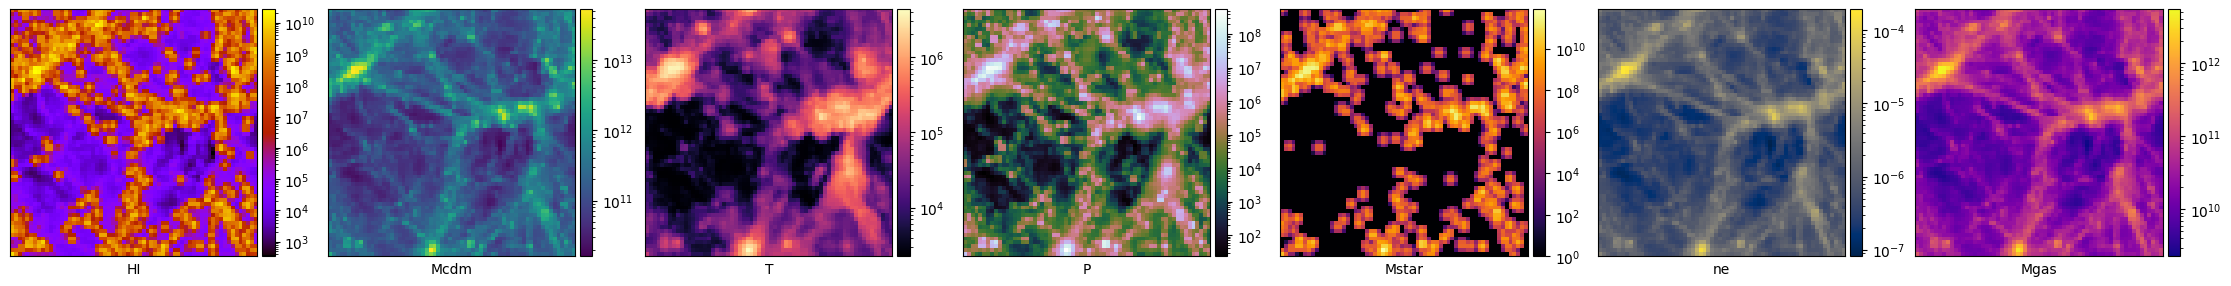

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
colormaps = {'HI':'gnuplot','Mcdm':'viridis','Mgas':'plasma','Mstar':'inferno','ne':'cividis','P':'cubehelix','T':'magma'}
fig,axs = plt.subplots(1,7,figsize=(28,4))
for i in range(7):
    arr = data.fields[12, i]
    im = axs[i].imshow(arr,norm='log',cmap=colormaps[data.field_names[i]])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel(data.field_names[i])

With a linear norm, everything looks very dark except few bright dots - galaxy clusters

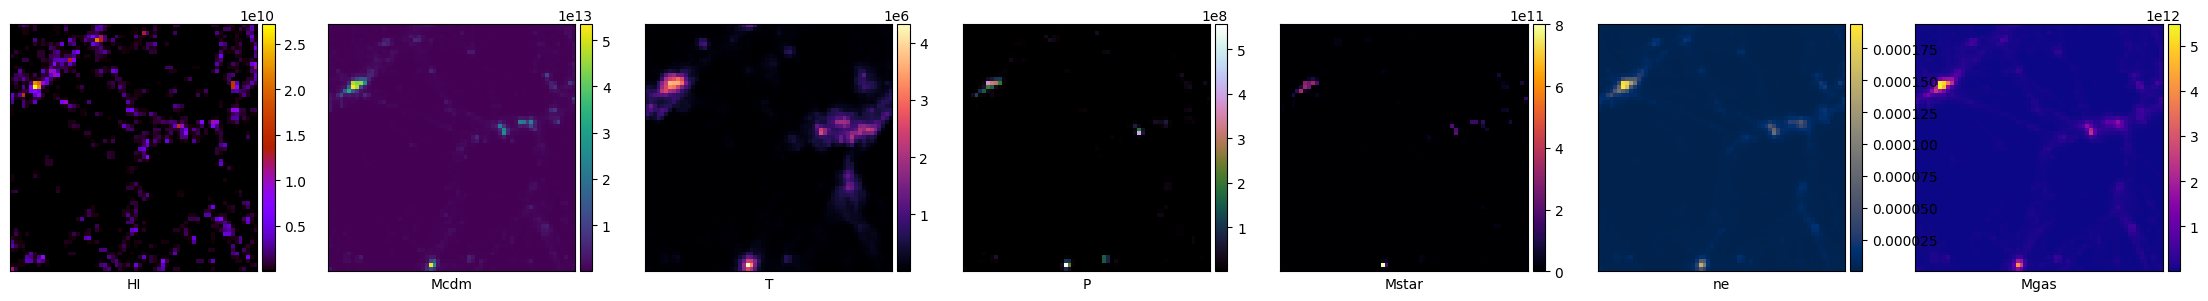

In [7]:
fig,axs = plt.subplots(1,7,figsize=(28,4))
for i in range(7):
    arr = data.fields[12, i]
    im = axs[i].imshow(arr,cmap=colormaps[data.field_names[i]])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel(data.field_names[i])

We are going to train a siple regressor to predict cosmological and astrophysical parameters from the simulations. There are 6 parameters in total - $\sigma_8$, $\Omega_m$, $A_{SN1}$, $A_{AGN1}$, $A_{SN2}$, $A_{GN2}$. The first two are cosmological parameters. $\Omega_m$ represents the fractional energy density of matter and $\sigma_8$ represents the variance of matter fluctuation at the scale of $8\ Mpc$ (it represents how clumpy matter is at this scale). Other parameters are simulation-specific (i.e. they don't have a universal meaning as constants of Nature). They parametrize strengths of different astrophysical processes that govern galaxy formation (physics of active gallactic nuclei (AGN) and supernovae feedback)

In [8]:
train_idx, val_idx = get_train_splits(6000, 0.8)
# we are going to log-normalize the data. i.e. y = log10(x), z = (y-E[y])/sqrt(V[y])
log_mean, log_std = np.log10(data.fields[train_idx]).mean(axis=(0,2,3)), np.log10(data.fields[train_idx]).std(axis=(0,2,3))
print(f'Means of log fields: {log_mean}')
print(f'Stds of log fields: {log_std}')

Means of log fields: [ 5.926398  11.050389   4.2571387  3.96287    2.501659  -6.003224
 10.4478445]
Stds of log fields: [1.9813877  0.5164814  0.8085728  1.4608783  3.508239   0.48313826
 0.48711914]


In [9]:
#Some utility transformations that we are going to need
class ToTensor:
    """Convert a NumPy array to a PyTorch tensor without changing axis order."""

    def __call__(self, array):
        """
        Args:
            array (np.ndarray): NumPy array with shape (C, H, W) or (H, W).

        Returns:
            torch.Tensor: Converted PyTorch tensor.
        """
        if not isinstance(array, np.ndarray):
            raise TypeError(f"Expected np.ndarray, but got {type(array)}")

        return torch.from_numpy(array).float()  # Converts to float32

    def __repr__(self):
        return f"{self.__class__.__name__}()"


class Log10Transform:
    def __call__(self, img):
        """
        Apply the base-10 logarithm to the input image tensor.
        Args:
            img (torch.Tensor): Input image tensor (assumed to have no zeros).
        Returns:
            torch.Tensor: The log10-transformed image.
        """
        if not torch.is_tensor(img):
            raise TypeError("Expected input to be a torch.Tensor")
        return torch.log10(img)

    def __repr__(self):
        return f"{self.__class__.__name__}()"



class RandomZ4ParityTransform:
    """Applies a random 90-degree rotation (Z_4 group) followed by a random reflection (parity transform Z_2^2)."""

    def __init__(self, parity_prob=1.0):
        """
        Args:
            parity_prob (float): Probability of applying a parity (flip) transformation. Default is 1.0 (always flip randomly).
        """
        self.k_values = [0, 1, 2, 3]  # 0°, 90°, 180°, 270° rotations
        self.parity_options = [
            (False, False),  # No flip (identity)
            (True, False),   # Flip x-axis
            (False, True),   # Flip y-axis
            (True, True)     # Flip both axes
        ]
        self.parity_prob = parity_prob  # Allows controlling whether parity transform is applied

    def __call__(self, img):
        """
        Args:
            img (torch.Tensor): Image tensor of shape (C, H, W) or (H, W).

        Returns:
            torch.Tensor: Transformed image with rotation and optional reflection.
        """
        # Apply random 90-degree rotation
        k = random.choice(self.k_values)
        img = torch.rot90(img, k, dims=(-2, -1))
        # Apply random parity (flip) with probability
        if random.random() < self.parity_prob:
            flip_x, flip_y = random.choice(self.parity_options)
            if flip_x:
                img = vflip(img)  # Flip along height (y-axis)
            if flip_y:
                img = hflip(img)  # Flip along width (x-axis)
        return img

    def __repr__(self):
        return f"{self.__class__.__name__}(parity_prob={self.parity_prob})"


class FieldInferenceDataset(Dataset):
    def __init__(self, data_array, target_array, transform=None, target_transform=None):
        """
        Args:
            data_array (np.ndarray): NumPy array with the input data.
            target_array (np.ndarray): NumPy array with the targets.
            transform (callable, optional): Function/transform to apply to the data.
            target_transform (callable, optional): Function/transform to apply to the targets.
        """
        if not isinstance(data_array, np.ndarray):
            raise TypeError("data_array must be a np.ndarray")
        if not isinstance(target_array, np.ndarray):
            raise TypeError("target_array must be a np.ndarray")
        if data_array.shape[0] != target_array.shape[0]:
            raise ValueError("data_array and target_array must have the same number of samples")
        self.data_array = data_array
        self.target_array = target_array
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x = self.data_array[index]
        y = self.target_array[index]
        if self.transform is not None:
            x = self.transform(x)
        if self.target_transform is not None:
            y = self.target_transform(y)
        return x, y

    def __len__(self):
        return self.data_array.shape[0]

In [10]:
#since the values of cosmological and astrophysical parameters don't care about the orientation, we are going to enforce that by applying random rotation and parity flips
#there're other ways to enforce symmetries in data
field_transforms = Compose([ToTensor(),
                           Log10Transform(),
                           Normalize(mean=torch.tensor(log_mean, dtype=torch.float32).view(-1,1,1), std=torch.tensor(log_std, dtype=torch.float32).view(-1,1,1)),
                           RandomZ4ParityTransform()])
target_transform = ToTensor()

train_data = FieldInferenceDataset(data.fields[train_idx], data.params[train_idx],
                                   transform=field_transforms, target_transform=target_transform)
valid_data = FieldInferenceDataset(data.fields[val_idx],data.params[val_idx],
                                   transform=field_transforms, target_transform=target_transform)

In [11]:
#simple inference model with a couple of layers
class SimpleInferenceModel(pl.LightningModule):
    def __init__(self, in_channels=7, output_dim=6, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # Feature extractor (CNN)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Fully connected regression head
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log("val_loss", loss, on_epoch=True)
        return loss

    def predict_step(self, batch, batch_idx):
        """Performs inference on a batch without computing gradients."""
        self.eval()  # Set model to evaluation mode
        x,y = batch
        with torch.no_grad():
            preds = self(x)
        return preds.cpu().numpy(), y.cpu().numpy()

#helper utility to log losses during traning
class MetricsCollector(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Retrieve the train_loss metric
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None and hasattr(train_loss, "cpu"):
            train_loss = train_loss.cpu().detach().item()
        self.train_losses.append(train_loss)
        print("Train epoch end, train_loss:", train_loss)

    def on_validation_epoch_end(self, trainer, pl_module):
        # Retrieve the val_loss metric
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None and hasattr(val_loss, "cpu"):
            val_loss = val_loss.cpu().detach().item()
        self.val_losses.append(val_loss)
        print("Validation epoch end, val_loss:", val_loss)

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=48)
val_loader = DataLoader(valid_data, batch_size=128, shuffle=False, num_workers=48)


metrics_collector = MetricsCollector()

#this is going to save the model only if the validation loss decreased
#i.e. it's an automatic early stopping to prevent overfitting
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath='./',
                                      filename=f"SimpleInferenceModel_IllustrisTNG",
                                      save_top_k=1, mode='min')

trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[checkpoint_callback, metrics_collector],
    #logger = tensorboard_logger,
    logger = False,
    precision = '16-mixed',
    devices=[0],
    accelerator='gpu',
    log_every_n_steps=5,
    )

model = SimpleInferenceModel()
#uncomment the following to run training
trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VI

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation epoch end, val_loss: 1.6724567413330078


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation epoch end, val_loss: 0.36559513211250305
Train epoch end, train_loss: 0.4617023169994354


Exception ignored in: <function _releaseLock at 0x7df0d65a6e80>
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


In [ ]:
#We can access the losses during training:
plt.plot(metrics_collector.train_losses[1:])
plt.plot(metrics_collector.val_losses[2:])

In [ ]:
#obtain the predictions using our trained model
predictions = trainer.predict(SimpleInferenceModel(), dataloaders=val_loader, ckpt_path='./SimpleInferenceModel_IllustrisTNG.ckpt')
model_predictions = np.concatenate([x[0] for x in predictions],axis=0)
true_values = np.concatenate([x[1] for x in predictions],axis=0)

### Task 1
1. Having the predictions and the true values, plot predictions vs. trues for each parameter. Which parameters can we predict well? Is our model biased?

In [ ]:
parameter_names = ["param_" + str(i) for i in range(model_predictions.shape[1])]

plt.figure(figsize=(15, 10))

for i in range(model_predictions.shape[1]):
    plt.subplot(3, 3, i + 1)
    plt.scatter(true_values[:, i], model_predictions[:, i], alpha=0.5, label=f'Predicted vs. True {parameter_names[i]}')
    plt.plot([min(true_values[:, i]), max(true_values[:, i])],
             [min(true_values[:, i]), max(true_values[:, i])], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predictions vs. True: {parameter_names[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

for i in range(model_predictions.shape[1]):
    bias = np.mean(model_predictions[:, i] - true_values[:, i])  # Mean error
    print(f"{parameter_names[i]}: Bias = {bias:.4f}")

We are able to predict Parameters 1 and 2 extremely well, 0 and 4 with some accuracy, but not parameters 5 and 3.

### Task 2
2. Quantify the results. Plot the distribution of $\delta = \hat{y}-y_{true}$.
Calculate the relative absolute error $\epsilon = \langle\frac{|y_{true}-\hat{y}|}{y_{true}}\rangle$
Calculate the coefficient of determination. The coefficient of determination \( R^2 \) is defined as:
$$R^2 = 1 - \frac{\sum (y_{\text{true}} - \hat{y})^2}{\sum (y_{\text{true}} - \bar{y}_{\text{true}})^2}$$
We want $R^2$ be as close to 1 as possible and $\epsilon$ as close to 0 as possible

In [ ]:
delta = model_predictions - true_values
plt.figure(figsize=(12, 6))
for i in range(delta.shape[1]):
    plt.hist(delta[:, i], bins=30, alpha=0.5, label=f"param_{i}")
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.xlabel("Prediction Error (δ)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (δ = ŷ - y_true)")
plt.legend()
plt.show()

epsilon = np.mean(np.abs((true_values - model_predictions) / true_values), axis=0)

ss_total = np.sum((true_values - np.mean(true_values, axis=0))**2, axis=0)
ss_residual = np.sum((true_values - model_predictions)**2, axis=0)
r_squared = 1 - (ss_residual / ss_total)

for i in range(delta.shape[1]):
    print(f"Parameter {i}: ε = {epsilon[i]:.4f}, R^2 = {r_squared[i]:.4f}")

### Task 3
Can we train a better model? Try to train the following architecture inspired by ResNet. Repeat the steps from Task 1 and 2. Is it better?

In [ ]:
# Define a basic residual block.
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# A ResNet-like model for inference using PyTorch Lightning.
class ResNetInferenceModel(pl.LightningModule):
    def __init__(self, in_channels=7, output_dim=6, lr=5e-4, wd=1e-2):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.wd = wd
        self.criterion = nn.MSELoss()

        # Initial convolutional layer (with larger kernel/stride like standard ResNet)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Four layers of residual blocks.
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)

        # Global average pooling and a fully connected head.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * BasicBlock.expansion, output_dim)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        # If the number of channels or stride differ, we need a downsample layer.
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution and pooling.
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual layers.
        x = self.layer1(x)
        x = self.layer2(x)

        # Global average pooling and classification/regression head.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        self.log("val_loss", loss, on_epoch=True)
        return loss


    def predict_step(self, batch, batch_idx):
        """Performs inference on a batch without computing gradients."""
        self.eval()  # Set model to evaluation mode
        x,y = batch
        with torch.no_grad():
            preds = self(x)
        return preds.cpu().numpy(), y.cpu().numpy()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.wd)

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=48)
val_loader = DataLoader(valid_data, batch_size=128, shuffle=False, num_workers=48)


metrics_collector = MetricsCollector()

#this is going to save the model only if the validation loss decreased
#i.e. it's an automatic early stopping to prevent overfitting
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath='./',
                                      filename=f"ResNetInferenceModel_IllustrisTNG",
                                      save_top_k=1, mode='min')

trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[checkpoint_callback, metrics_collector],
    #logger = tensorboard_logger,
    logger = False,
    precision = '16-mixed',
    devices=[0],
    accelerator='gpu',
    log_every_n_steps=5,
    )

model = ResNetInferenceModel()
#uncomment the following to run training
trainer.fit(model, train_loader, val_loader)

In [ ]:
plt.plot(metrics_collector.train_losses[1:])
plt.plot(metrics_collector.val_losses[2:])

predictions = trainer.predict(ResNetInferenceModel(), dataloaders=val_loader, ckpt_path='./ResNetInferenceModel_IllustrisTNG.ckpt')
model_predictions = np.concatenate([x[0] for x in predictions],axis=0)
true_values = np.concatenate([x[1] for x in predictions],axis=0)

parameter_names = ["param_" + str(i) for i in range(model_predictions.shape[1])]

plt.figure(figsize=(15, 10))

for i in range(model_predictions.shape[1]):
    plt.subplot(3, 3, i + 1)
    plt.scatter(true_values[:, i], model_predictions[:, i], alpha=0.5, label=f'Predicted vs. True {parameter_names[i]}')
    plt.plot([min(true_values[:, i]), max(true_values[:, i])],
             [min(true_values[:, i]), max(true_values[:, i])], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predictions vs. True: {parameter_names[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

for i in range(model_predictions.shape[1]):
    bias = np.mean(model_predictions[:, i] - true_values[:, i])  # Mean error
    print(f"{parameter_names[i]}: Bias = {bias:.4f}")

delta = model_predictions - true_values
plt.figure(figsize=(12, 6))
for i in range(delta.shape[1]):
    plt.hist(delta[:, i], bins=30, alpha=0.5, label=f"param_{i}")
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.xlabel("Prediction Error (δ)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (δ = ŷ - y_true)")
plt.legend()
plt.show()

epsilon = np.mean(np.abs((true_values - model_predictions) / true_values), axis=0)

ss_total = np.sum((true_values - np.mean(true_values, axis=0))**2, axis=0)
ss_residual = np.sum((true_values - model_predictions)**2, axis=0)
r_squared = 1 - (ss_residual / ss_total)

for i in range(delta.shape[1]):
    print(f"Parameter {i}: ε = {epsilon[i]:.4f}, R^2 = {r_squared[i]:.4f}")

With Resnet, we can see that some of the parameter's bias has gone down significantly, such as Parameter 0. Additionally, the R^2 for some of the parameters also increased, leading to a greater correlation.

### Task 4
Now check how our model will perform on another set of simulations. We don't expect it to perform well on the astrophysical parameters $A_{agn1,2}$, $A_{snn1,2}$, but how does it perform for cosmological parameters? Make the plots and calculate the metrics as in the previous tasks. Interpret the results.

In [ ]:
# Load new dataset
data2 = Data('./Maps_red_SIMBA_LH_z=000.npz')
print(data2.field_names)
print(data2.fields.shape)

train_idx, val_idx = get_train_splits(6000, 0.8)
log_mean, log_std = np.log10(data2.fields[train_idx]).mean(axis=(0,2,3)), np.log10(data2.fields[train_idx]).std(axis=(0,2,3))
print(f'Means of log fields: {log_mean}')
print(f'Stds of log fields: {log_std}')

field_transforms = Compose([ToTensor(),
                           Log10Transform(),
                           Normalize(mean=torch.tensor(log_mean, dtype=torch.float32).view(-1,1,1), std=torch.tensor(log_std, dtype=torch.float32).view(-1,1,1)),
                           RandomZ4ParityTransform()])
target_transform = ToTensor()

train_data = FieldInferenceDataset(data2.fields[train_idx], data2.params[train_idx],
                                   transform=field_transforms, target_transform=target_transform)
valid_data = FieldInferenceDataset(data2.fields[val_idx],data2.params[val_idx],
                                   transform=field_transforms, target_transform=target_transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=48)
val_loader = DataLoader(valid_data, batch_size=128, shuffle=False, num_workers=48)


metrics_collector = MetricsCollector()

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath='./',
                                      filename=f"SimpleInferenceModel_IllustrisTNG",
                                      save_top_k=1, mode='min')

trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[checkpoint_callback, metrics_collector],
    #logger = tensorboard_logger,
    logger = False,
    precision = '16-mixed',
    devices=[0],
    accelerator='gpu',
    log_every_n_steps=5,
    )

model = SimpleInferenceModel()
trainer.fit(model, train_loader, val_loader)

In [ ]:
plt.plot(metrics_collector.train_losses[1:])
plt.plot(metrics_collector.val_losses[2:])

predictions = trainer.predict(SimpleInferenceModel(), dataloaders=val_loader, ckpt_path='./SimpleInferenceModel_IllustrisTNG.ckpt')
model_predictions = np.concatenate([x[0] for x in predictions],axis=0)
true_values = np.concatenate([x[1] for x in predictions],axis=0)

parameter_names = ["param_" + str(i) for i in range(model_predictions.shape[1])]

plt.figure(figsize=(15, 10))

for i in range(model_predictions.shape[1]):
    plt.subplot(3, 3, i + 1)
    plt.scatter(true_values[:, i], model_predictions[:, i], alpha=0.5, label=f'Predicted vs. True {parameter_names[i]}')
    plt.plot([min(true_values[:, i]), max(true_values[:, i])],
             [min(true_values[:, i]), max(true_values[:, i])], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predictions vs. True: {parameter_names[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

for i in range(model_predictions.shape[1]):
    bias = np.mean(model_predictions[:, i] - true_values[:, i])  # Mean error
    print(f"{parameter_names[i]}: Bias = {bias:.4f}")

delta = model_predictions - true_values
plt.figure(figsize=(12, 6))
for i in range(delta.shape[1]):
    plt.hist(delta[:, i], bins=30, alpha=0.5, label=f"param_{i}")
plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
plt.xlabel("Prediction Error (δ)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (δ = ŷ - y_true)")
plt.legend()
plt.show()

epsilon = np.mean(np.abs((true_values - model_predictions) / true_values), axis=0)

ss_total = np.sum((true_values - np.mean(true_values, axis=0))**2, axis=0)
ss_residual = np.sum((true_values - model_predictions)**2, axis=0)
r_squared = 1 - (ss_residual / ss_total)

for i in range(delta.shape[1]):
    print(f"Parameter {i}: ε = {epsilon[i]:.4f}, R^2 = {r_squared[i]:.4f}")

As expected, this model does not function well on the other data set. However, it is still capable of significant predictions of both param 1 and param 2.

### Field to Field Inference
Another task is to be able to predict the unobservable from observable. The distribution of dark matter is never observable. In this case, we are going to assume that we observe everything else (a strong assumption!) and try to train a model that infers the dark matter. We are going to stack our observed fields and use image-to-image prediction techniques, treating different fields as channels. Run the code below

In [ ]:
print(data.field_names)
input_field_indices = [0,2,3,4,5,6]
output_field_indices = [1]

#we need to normalize the outputs as well
out_mean, out_std = data.fields[train_idx,output_field_indices].mean(), data.fields[train_idx,output_field_indices].std()

field_transforms = Compose([ToTensor(),
                           Log10Transform(),
                           Normalize(mean=torch.tensor(log_mean[input_field_indices], dtype=torch.float32).view(-1,1,1), std=torch.tensor(log_std[input_field_indices], dtype=torch.float32).view(-1,1,1))])

target_transforms = Compose([ToTensor(), Normalize(mean = torch.tensor(out_mean, dtype=torch.float32), std = torch.tensor(out_std, dtype=torch.float32))])

train_data = FieldInferenceDataset(data.fields[train_idx][:,input_field_indices,...], data.fields[train_idx][:,output_field_indices,...].reshape(-1,1,64,64),
                                   transform=field_transforms, target_transform=target_transforms)
valid_data = FieldInferenceDataset(data.fields[val_idx][:,input_field_indices,...], data.fields[val_idx][:,output_field_indices,...].reshape(-1,1,64,64),
                                   transform=field_transforms, target_transform=target_transforms)

In [ ]:
#The simulation data is preiodic and we have to respect the periodicity by choosing circular padding
class LitSimpleF2F(pl.LightningModule):
    def __init__(self, n_in, n_out, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Conv2d(n_in, 32, kernel_size=3, padding=1, padding_mode='circular'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, padding_mode='circular'),
            nn.ReLU(),
            nn.Conv2d(32, n_out, kernel_size=3, padding=1, padding_mode='circular')
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


    def predict_step(self, batch, batch_idx):
        """Performs inference on a batch without computing gradients."""
        self.eval()  # Set model to evaluation mode
        x,y = batch
        with torch.no_grad():
            preds = self(x)
        return preds.cpu(), y.cpu()


model = LitSimpleF2F(n_in=6, n_out=1)

In [ ]:
metrics_collector = MetricsCollector()

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath='./',
                                      filename=f"SimpleF2F",
                                      save_top_k=1, mode='min')

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=48)
val_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=48)

trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[metrics_collector, checkpoint_callback],
    precision = '16-mixed',
    devices=[0],
    accelerator='gpu',
    logger=False
)

In [ ]:
#uncomment to run
trainer.fit(model, train_loader, val_loader)

In [ ]:
#we need to scale back the predictions
class InverseNormalize:
    def __init__(self, mean, std):
        self.mean = mean.view(-1)
        self.std = std.view(-1)

    def __call__(self, tensor):
        # Support both single images (C, H, W) and batched images (B, C, H, W)
        if tensor.ndim == 3:
            mean = self.mean[:, None, None]
            std = self.std[:, None, None]
        elif tensor.ndim == 4:
            mean = self.mean[None, :, None, None]
            std = self.std[None, :, None, None]
        else:
            raise ValueError("Unsupported tensor shape")
        return tensor * std + mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean.tolist()}, std={self.std.tolist()})"

inv_normalize = InverseNormalize(mean = torch.tensor(out_mean, dtype=torch.float32), std = torch.tensor(out_std, dtype=torch.float32))

predictions = trainer.predict(model, dataloaders=val_loader, ckpt_path='./SimpleF2F.ckpt')
model_predictions = inv_normalize(torch.cat([x[0] for x in predictions],axis=0)).numpy()
true_values = inv_normalize(torch.cat([x[1] for x in predictions],axis=0)).numpy()

In [ ]:
#let's plot some results
idxs = np.random.choice(model_predictions.shape[0],8,replace=False)
fig, axs = plt.subplots(2,8,figsize=(28,6))
for i in range(8):
    axs[0, i].imshow(model_predictions[idxs[i],0], norm='log')
    axs[1, i].imshow(true_values[idxs[i],0], norm='log')

In [ ]:
fig, axs = plt.subplots(2,8,figsize=(28,6))
for i in range(8):
    axs[0, i].imshow(model_predictions[idxs[i],0])
    axs[1, i].imshow(true_values[idxs[i],0])

One useful in cosmology metric is a cross correlation coefficient of the Fourier modes.

The cross-correlation coefficient in Fourier ($ k $)-space is defined as:

$$
r(k) = \frac{P_{XY}(k)}{\sqrt{P_X(k) P_Y(k)}}
$$

where:

- $P_{XY}(k)$ is the **cross-power spectrum**, defined as:
  $$
  P_{XY}(k) = \langle X(\mathbf{k}) Y^*(\mathbf{k}) \rangle,
  $$
  where $X(\mathbf{k})$ and $Y(\mathbf{k})$ are the Fourier transforms of the fields $X(\mathbf{x})$ and  $Y(\mathbf{x})$.
  
- $P_X(k)$ and $P_Y(k)$ are the **auto-power spectra**, given by:
  $$
  P_X(k) = \langle |X(\mathbf{k})|^2 \rangle, \quad P_Y(k) = \langle |Y(\mathbf{k})|^2 \rangle.
  $$

- The angle brackets $\langle \cdot \rangle$ denote an ensemble or shell average over wavevectors $\mathbf{k}$ at a fixed magnitude $k$.

The correlation coefficient $r(k)$ satisfies:

$$
-1 \leq r(k) \leq 1,
$$

where $r(k) = 1$ implies perfect correlation, and $r(k) = -1$ implies perfect anti-correlation.

In [ ]:
import Pk_library as PKL
def cross_r(delta1, delta2):
    BoxSize = 25.0 #Mpc/h
    MAS1    = 'CIC'
    MAS2    = 'None'
    threads = 24

    # compute cross-power spectrum between two images
    XPk2D = PKL.XPk_plane(delta1, delta2, BoxSize, MAS1, MAS2, threads)

    # get the attributes of the routine
    k      = XPk2D.k        #k in h/Mpc
    r      = XPk2D.r        #cross-correlation coefficient
    return k, r

In [ ]:
def get_r(trues,preds):
    rs = []
    for i in range(len(trues)):
        k,r = cross_r(trues[i,0], preds[i,0])
        rs.append(r)
    return k[:-5],np.array(rs)[:,:-5]
k,rs = get_r(true_values, model_predictions)

In [ ]:
fig, axs = plt.subplots(1,8,figsize=(28,4))
for i in range(8):
    axs[i].plot(k,rs[idxs[i]])
    axs[i].set_ylim(0.8,1)
    axs[i].grid()

In [ ]:
#plot the mean and +- 1 sigma over the datatset
r_mean = rs.mean(axis=0)
r_std = rs.std(axis=0)
plt.plot(k,r_mean,color='black')
plt.fill_between(k, r_mean-r_std, r_mean+r_std,alpha=0.5)

In [ ]:
#calculate the average over the k range:
from scipy.integrate import trapz
trapz(r_mean,k)/(k.max()-k.min())

### Task 5
Let's make a more realistic assumption that we only observe the stellar mass directly. Train the model to predict the dark matter mass distribution Mcdm from the observed stellar mass only (Mstar). Plot the results. Calculate the cross correlation coefficeint (as in the previous task)

In [ ]:
print(data.field_names)
input_field_indices = [4] # Define only Mstar as Input.
output_field_indices = [1]

#we need to normalize the outputs as well
out_mean, out_std = data.fields[train_idx,output_field_indices].mean(), data.fields[train_idx,output_field_indices].std()

field_transforms = Compose([ToTensor(),
                           Log10Transform(),
                           Normalize(mean=torch.tensor(log_mean[input_field_indices], dtype=torch.float32).view(-1,1,1), std=torch.tensor(log_std[input_field_indices], dtype=torch.float32).view(-1,1,1))])

target_transforms = Compose([ToTensor(), Normalize(mean = torch.tensor(out_mean, dtype=torch.float32), std = torch.tensor(out_std, dtype=torch.float32))])

train_data = FieldInferenceDataset(data.fields[train_idx][:,input_field_indices,...], data.fields[train_idx][:,output_field_indices,...].reshape(-1,1,64,64),
                                   transform=field_transforms, target_transform=target_transforms)
valid_data = FieldInferenceDataset(data.fields[val_idx][:,input_field_indices,...], data.fields[val_idx][:,output_field_indices,...].reshape(-1,1,64,64),
                                   transform=field_transforms, target_transform=target_transforms)

model = LitSimpleF2F(n_in=1, n_out=1)

In [ ]:
metrics_collector = MetricsCollector()

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath='./',
                                      filename=f"SimpleF2F",
                                      save_top_k=1, mode='min')

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=48)
val_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=48)

trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[metrics_collector, checkpoint_callback],
    precision = '16-mixed',
    devices=[0],
    accelerator='gpu',
    logger=False
)

In [ ]:
trainer.fit(model, train_loader, val_loader)

In [ ]:
inv_normalize = InverseNormalize(mean = torch.tensor(out_mean, dtype=torch.float32), std = torch.tensor(out_std, dtype=torch.float32))

predictions = trainer.predict(model, dataloaders=val_loader, ckpt_path='./SimpleF2F.ckpt')
model_predictions = inv_normalize(torch.cat([x[0] for x in predictions],axis=0)).numpy()
true_values = inv_normalize(torch.cat([x[1] for x in predictions],axis=0)).numpy()

idxs = np.random.choice(model_predictions.shape[0],8,replace=False)

In [ ]:
fig, axs = plt.subplots(2,8,figsize=(28,6))
for i in range(8):
    axs[0, i].imshow(model_predictions[idxs[i],0], norm='log')
    axs[1, i].imshow(true_values[idxs[i],0], norm='log')

In [ ]:
fig, axs = plt.subplots(2,8,figsize=(28,6))
for i in range(8):
    axs[0, i].imshow(model_predictions[idxs[i],0])
    axs[1, i].imshow(true_values[idxs[i],0])

In [ ]:
fig, axs = plt.subplots(1,8,figsize=(28,4))
for i in range(8):
    axs[i].plot(k,rs[idxs[i]])
    axs[i].set_ylim(0.8,1)
    axs[i].grid()

In [ ]:
r_mean = rs.mean(axis=0)
r_std = rs.std(axis=0)
plt.plot(k,r_mean,color='black')
plt.fill_between(k, r_mean-r_std, r_mean+r_std,alpha=0.5)

trapz(r_mean,k)/(k.max()-k.min())

### Optional
There are better-suited architectures for the image-to-image mapping tasks. One of them is [U-Net](https://arxiv.org/abs/1505.04597) Try it out!